In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb
import os

os.makedirs("new_figures/ml_biomarkers", exist_ok=True)

# Load data
adata = sc.read_h5ad('lee2020_processed.h5ad')

# y = target (Tumor = 1, Normal = 0)
adata.obs['label'] = (adata.obs['CONDITION'] == 'Tumor').astype(int)

# X = expression matrix (2192 genes manageable)
X = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
                 index=adata.obs_names,
                 columns=adata.var_names)

y = adata.obs['label'].values

print("X shape:", X.shape)
print("Class distribution:\n", pd.Series(y).value_counts())

X shape: (61370, 2192)
Class distribution:
 1    45724
0    15646
Name: count, dtype: int64


In [2]:
# Highly variable genes + top DE genes combine করো
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
hvg = adata.var_names[adata.var['highly_variable']]

# তোমার আগের DE top genes যোগ করো (extra power)
top_de = ['CEACAM5','CEACAM6','TFF3','LCN2','AGR2','EPCAM','S100P','CXCL8',
          'KRT18','CLDN4','MAL2','GDF15','KRT19','RAB25','ELF3','GPX2']

features = list(set(hvg.tolist() + top_de))
features = [g for g in features if g in X.columns]

X_ml = X[features].copy()

print(f"Final features for ML: {X_ml.shape[1]} genes")

Final features for ML: 1004 genes


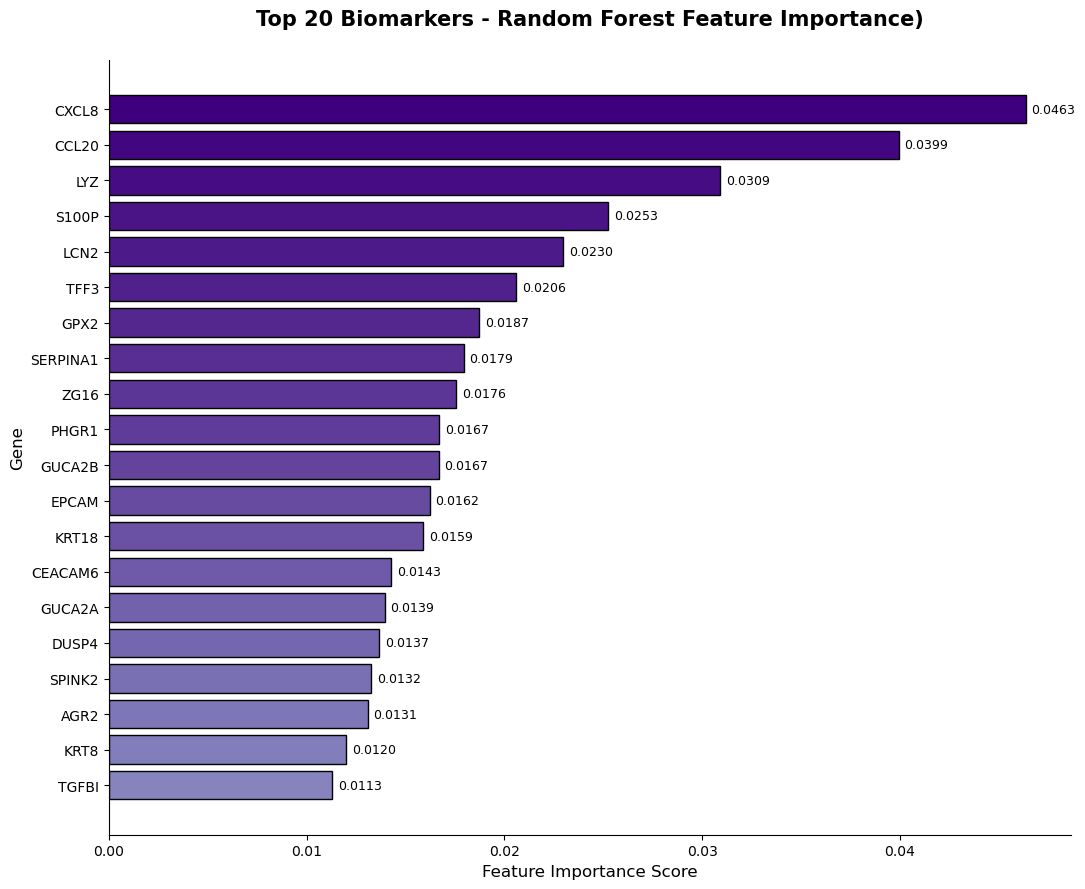

Random Forest Top 10:
          gene  importance
619     CXCL8    0.046347
897     CCL20    0.039927
204       LYZ    0.030891
290     S100P    0.025258
851      LCN2    0.022986
542      TFF3    0.020593
301      GPX2    0.018728
979  SERPINA1    0.017943
327      ZG16    0.017557
759     PHGR1    0.016719


In [3]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=12,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf.fit(X_ml, y)

# Feature importance
importances = pd.DataFrame({
    'gene': X_ml.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20
top20_rf = importances.head(20).copy()

# Plot - Traditional style
fig, ax = plt.subplots(figsize=(11, 9))
colors = plt.cm.Purples(np.linspace(0.6, 1.0, 20))
bars = ax.barh(top20_rf['gene'][::-1], top20_rf['importance'][::-1], color=colors, edgecolor='black')

ax.set_title('Top 20 Biomarkers - Random Forest Feature Importance)', 
             fontsize=15, fontweight='bold', pad=25)
ax.set_xlabel('Feature Importance Score', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

for bar in bars:
    ax.text(bar.get_width() + 0.0003, bar.get_y() + bar.get_height()/2,
            f'{bar.get_width():.4f}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("new_figures/ml_biomarkers/rf_top20_biomarkers.png", dpi=400, bbox_inches='tight')
plt.show()

print("Random Forest Top 10:\n", top20_rf.head(10))

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import os

os.makedirs("new_figures/ml_biomarkers", exist_ok=True)

# Data
#adata = sc.read_h5ad('lee2020_processed.h5ad')
adata.obs['label'] = (adata.obs['CONDITION'] == 'Tumor').astype(int)

X = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X,
                 columns=adata.var_names)

y = adata.obs['label'].values

# Features (HVG + top DE)
sc.pp.highly_variable_genes(adata, n_top_genes=1000)
hvg = adata.var_names[adata.var['highly_variable']]
top_de = ['CEACAM5','CEACAM6','TFF3','LCN2','AGR2','EPCAM','S100P','CXCL8',
          'KRT18','CLDN4','MAL2','GDF15','KRT19','RAB25','ELF3','GPX2']
features = list(set(hvg.tolist() + top_de))
features = [g for g in features if g in X.columns]

X_ml = X[features]

# Train-Test Split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y, test_size=0.25, stratify=y, random_state=42
)

print("Train/Test split done. Train size:", X_train.shape, "Test size:", X_test.shape)

Train/Test split done. Train size: (46027, 1004) Test size: (15343, 1004)


CELL 2: Random Forest + Accuracy & Metrics + Plot


Random Forest Results:
Accuracy: 0.8677
AUC-ROC: 0.9536

Classification Report:
               precision    recall  f1-score   support

      Normal       0.69      0.88      0.77      3912
       Tumor       0.96      0.86      0.91     11431

    accuracy                           0.87     15343
   macro avg       0.82      0.87      0.84     15343
weighted avg       0.89      0.87      0.87     15343



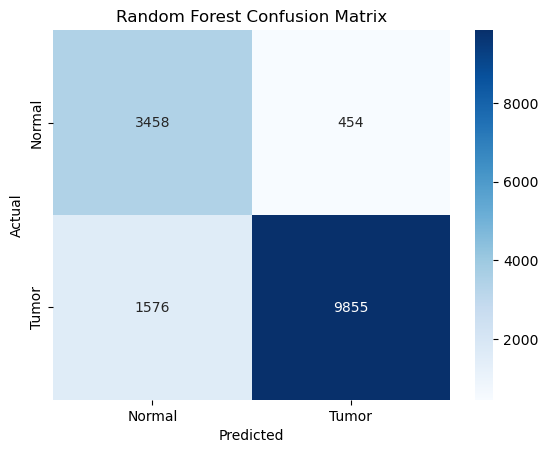

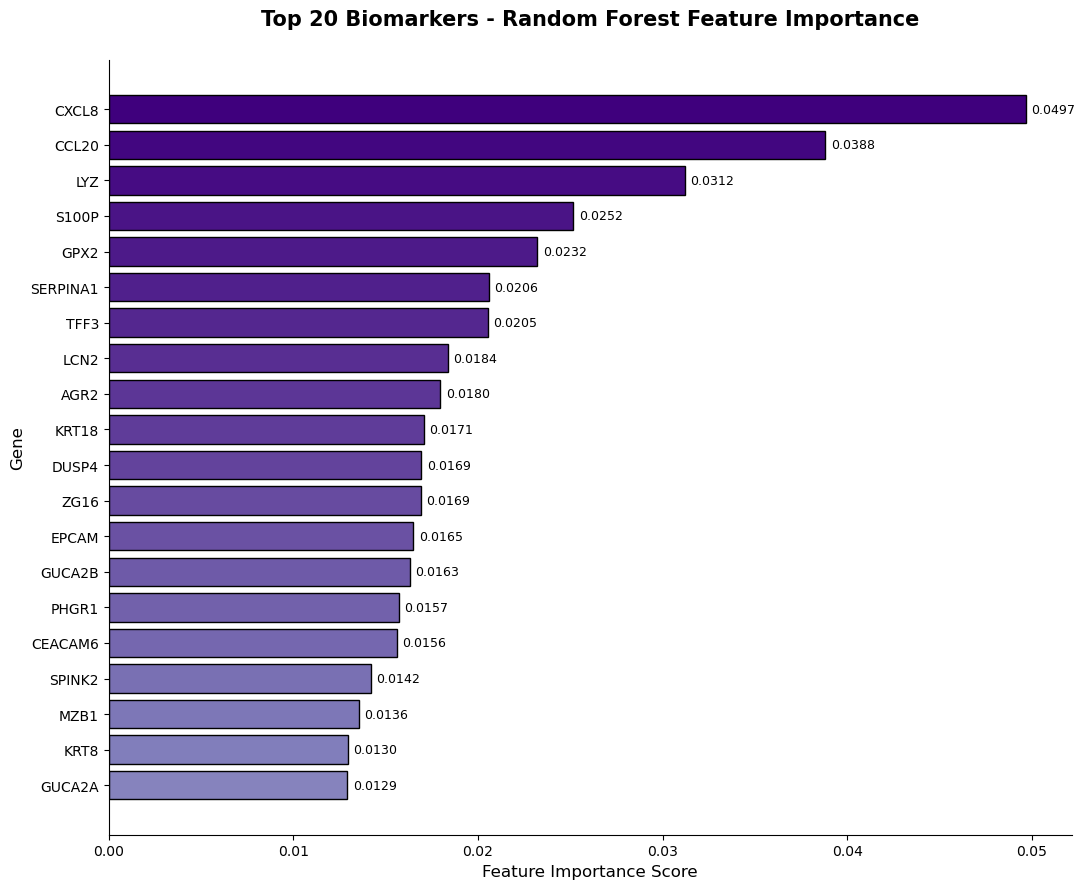

In [5]:
rf = RandomForestClassifier(n_estimators=300, max_depth=10, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predictions & Metrics
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
report = classification_report(y_test, y_pred, target_names=['Normal', 'Tumor'])

print("\nRandom Forest Results:")
print(f"Accuracy: {acc:.4f}")
print(f"AUC-ROC: {auc:.4f}")
print("\nClassification Report:\n", report)

# Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("new_figures/ml_biomarkers/rf_confusion_matrix.png", dpi=300)
plt.show()

# Top 20 Biomarkers Plot
importances = pd.DataFrame({'gene': X_ml.columns, 'importance': rf.feature_importances_})
top20_rf = importances.sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(11, 9))
colors = plt.cm.Purples(np.linspace(0.6, 1.0, 20))
bars = ax.barh(top20_rf['gene'][::-1], top20_rf['importance'][::-1], color=colors, edgecolor='black')

ax.set_title('Top 20 Biomarkers - Random Forest Feature Importance', 
             fontsize=15, fontweight='bold', pad=25)
ax.set_xlabel('Feature Importance Score', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

for bar in bars:
    ax.text(bar.get_width() + 0.0003, bar.get_y() + bar.get_height()/2,
            f'{bar.get_width():.4f}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("new_figures/ml_biomarkers/rf_top20_with_accuracy.png", dpi=400, bbox_inches='tight')
plt.show()

CELL 3: XGBoost + Metrics + Plot

In [6]:
# CELL: Ultimate Gene Name Cleaning for XGBoost
import re

# Keep only alphanumeric + underscore, replace everything else
def clean_gene_name(name):
    # Remove invalid chars, keep a-zA-Z0-9_
    cleaned = re.sub(r'[^a-zA-Z0-9_]', '_', str(name))
    # Remove multiple _ in a row
    cleaned = re.sub(r'_+', '_', cleaned)
    # Trim leading/trailing _
    cleaned = cleaned.strip('_')
    # If empty after clean, make generic
    if not cleaned:
        return 'gene_unknown'
    return cleaned

# Apply to adata.var_names
adata.var_names = [clean_gene_name(g) for g in adata.var_names]

# Apply to X_ml columns
X_ml.columns = [clean_gene_name(g) for g in X_ml.columns]

# Also apply to X_train and X_test (since they are views/slices)
X_train.columns = X_ml.columns
X_test.columns = X_ml.columns

print("All gene names cleaned and XGBoost-safe!")
print("First 10 cleaned gene names:", X_ml.columns[:10].tolist())
print("Any invalid left?", any(re.search(r'[\[\]<>]', g) for g in X_ml.columns))

All gene names cleaned and XGBoost-safe!
First 10 cleaned gene names: ['SLC4A10', 'BEST4', 'GBP2', 'GLUL', 'CDK1', 'IRF9', 'MAOB', 'KRT18', 'TM4SF4', 'RND3']
Any invalid left? False



XGBoost Results:
Accuracy: 0.9518
AUC-ROC: 0.9896

Classification Report:
               precision    recall  f1-score   support

      Normal       0.88      0.93      0.91      3912
       Tumor       0.98      0.96      0.97     11431

    accuracy                           0.95     15343
   macro avg       0.93      0.95      0.94     15343
weighted avg       0.95      0.95      0.95     15343



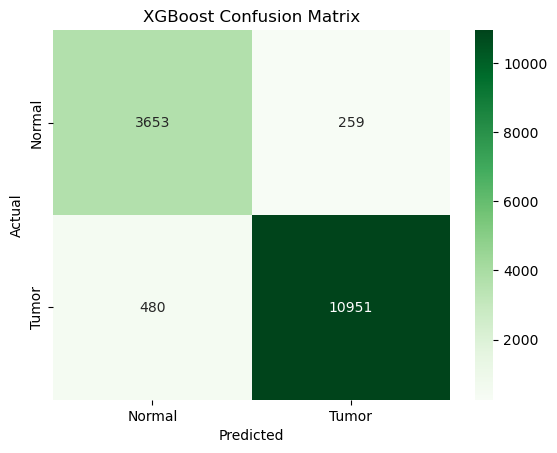

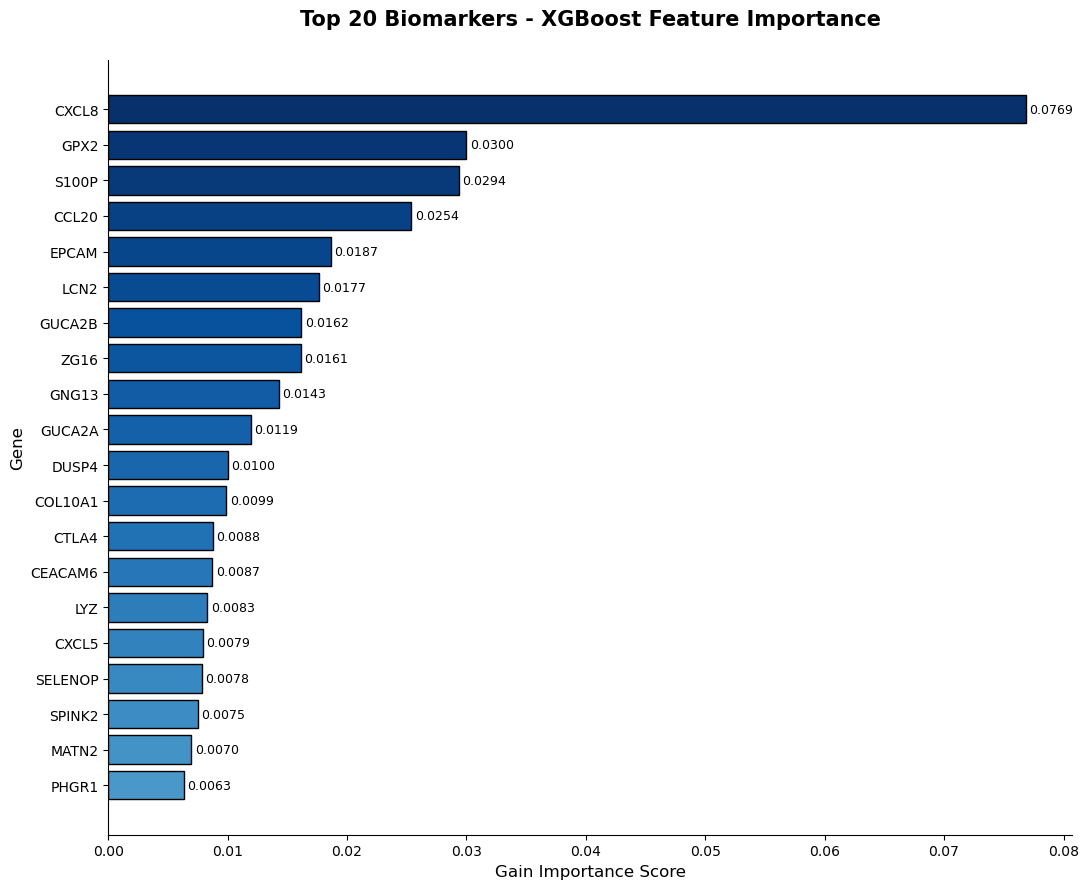

In [7]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    scale_pos_weight = sum(y_train==0)/sum(y_train==1),
    random_state=42,
    eval_metric='auc',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# Metrics
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_prob_xgb)

print("\nXGBoost Results:")
print(f"Accuracy: {acc_xgb:.4f}")
print(f"AUC-ROC: {auc_xgb:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=['Normal', 'Tumor']))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("new_figures/ml_biomarkers/xgb_confusion_matrix.png", dpi=300)
plt.show()

# Top 20 Plot with Accuracy
xgb_imp = pd.DataFrame({'gene': X_ml.columns, 'importance': xgb_model.feature_importances_})
top20_xgb = xgb_imp.sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(11, 9))
colors = plt.cm.Blues(np.linspace(0.6, 1.0, 20))
bars = ax.barh(top20_xgb['gene'][::-1], top20_xgb['importance'][::-1], color=colors, edgecolor='black')

ax.set_title('Top 20 Biomarkers - XGBoost Feature Importance',
             fontsize=15, fontweight='bold', pad=25)
ax.set_xlabel('Gain Importance Score', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

for bar in bars:
    ax.text(bar.get_width() + 0.0003, bar.get_y() + bar.get_height()/2,
            f'{bar.get_width():.4f}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("new_figures/ml_biomarkers/xgb_top20_with_accuracy.png", dpi=400, bbox_inches='tight')
plt.show()

CELL 5: Lasso Logistic Regression + Plot

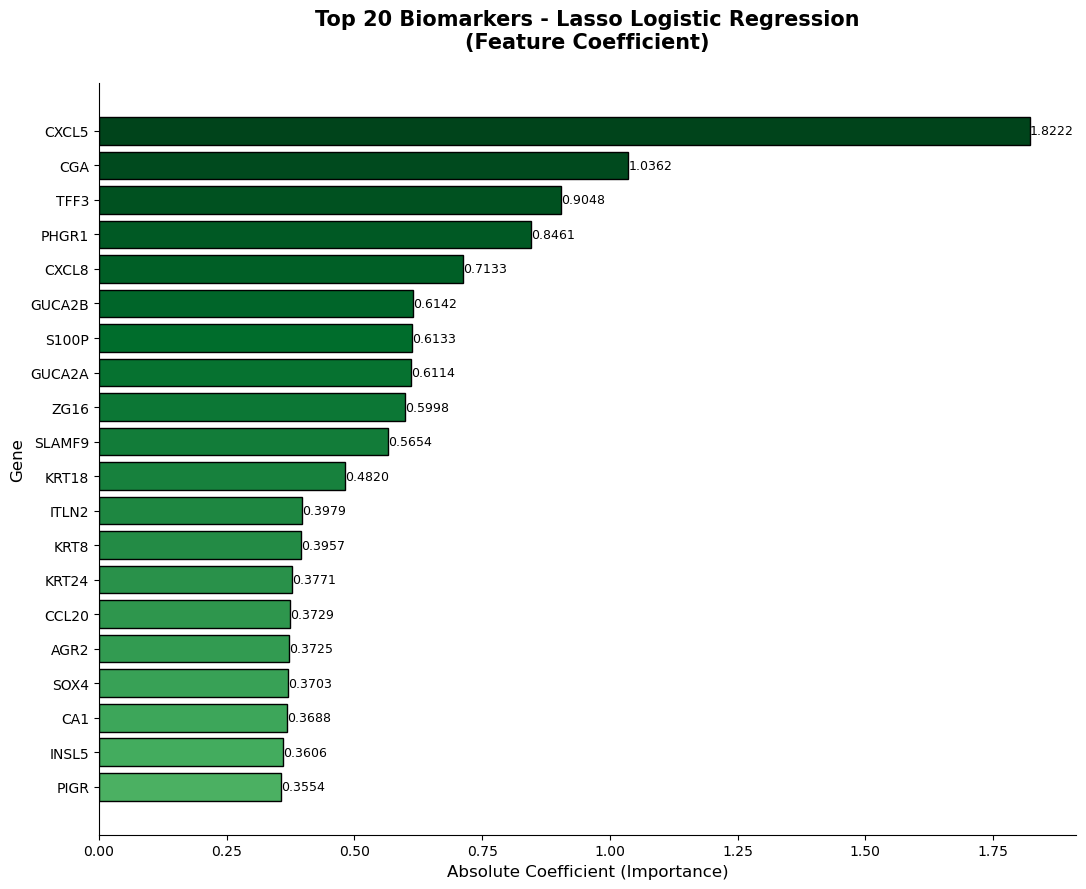

In [15]:
lasso = LogisticRegression(
    penalty='l1',
    solver='liblinear',
    C=0.1,                    # smaller C = stronger regularization
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

lasso.fit(X_ml, y)

lasso_imp = pd.DataFrame({
    'gene': X_ml.columns,
    'importance': np.abs(lasso.coef_[0])
}).sort_values('importance', ascending=False)

top20_lasso = lasso_imp.head(20)

# Plot
fig, ax = plt.subplots(figsize=(11, 9))
colors = plt.cm.Greens(np.linspace(0.6, 1.0, 20))
bars = ax.barh(top20_lasso['gene'][::-1], top20_lasso['importance'][::-1], color=colors, edgecolor='black')

ax.set_title('Top 20 Biomarkers - Lasso Logistic Regression\n(Feature Coefficient)', 
             fontsize=15, fontweight='bold', pad=25)
ax.set_xlabel('Absolute Coefficient (Importance)', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

for bar in bars:
    ax.text(bar.get_width() + 0.0003, bar.get_y() + bar.get_height()/2,
            f'{bar.get_width():.4f}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("new_figures/ml_biomarkers/lasso_top20_biomarkers.png", dpi=400, bbox_inches='tight')
plt.show()

Training SVM... (may take time on CPU)


/home/nazmulhasan77/miniconda3/envs/rnaseq/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(



SVM Results:
Accuracy: 0.2550
AUC-ROC: 0.8585

Classification Report:
               precision    recall  f1-score   support

      Normal       0.25      1.00      0.41      3912
       Tumor       1.00      0.00      0.00     11431

    accuracy                           0.26     15343
   macro avg       0.63      0.50      0.20     15343
weighted avg       0.81      0.26      0.10     15343



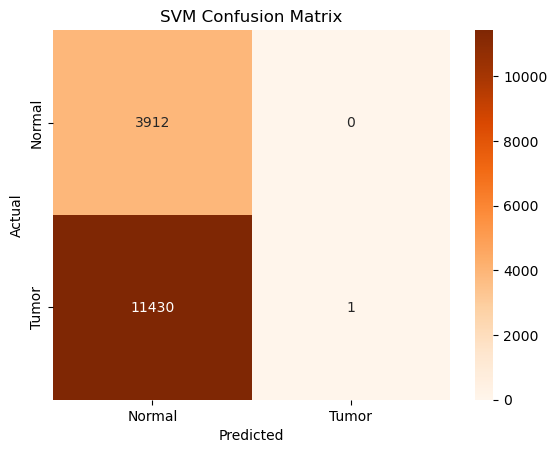

Calculating permutation importance for SVM... (may take time)


In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

os.makedirs("new_figures/ml_biomarkers", exist_ok=True)

# SVM model (RBF kernel, probability=True যাতে AUC পাওয়া যায়)
svm_model = SVC(
    kernel='rbf',           # non-linear, CRC data-এ ভালো কাজ করে
    C=1.0,                  # regularization
    probability=True,       # AUC-এর জন্য দরকার
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)

# অথবা LinearSVC (যদি faster চাও, কিন্তু probability নেই)
# svm_model = LinearSVC(class_weight='balanced', random_state=42, max_iter=2000)

print("Training SVM... (may take time on CPU)")
svm_model.fit(X_train, y_train)

# Predictions & Metrics
y_pred_svm = svm_model.predict(X_test)

# Probability (SVC-এর জন্য predict_proba আছে)
if hasattr(svm_model, 'predict_proba'):
    y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
    auc_svm = roc_auc_score(y_test, y_prob_svm)
else:
    # LinearSVC-এ probability নেই — decision function use করো
    y_decision = svm_model.decision_function(X_test)
    auc_svm = roc_auc_score(y_test, y_decision)

acc_svm = accuracy_score(y_test, y_pred_svm)

print("\nSVM Results:")
print(f"Accuracy: {acc_svm:.4f}")
print(f"AUC-ROC: {auc_svm:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm, target_names=['Normal', 'Tumor']))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Normal', 'Tumor'], yticklabels=['Normal', 'Tumor'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("new_figures/ml_biomarkers/svm_confusion_matrix.png", dpi=300)
plt.show()

# Top 20 Biomarkers (Permutation Importance)
print("Calculating permutation importance for SVM... (may take time)")
perm_imp_svm = permutation_importance(
    svm_model,
    X_test, y_test,
    n_repeats=5,
    random_state=42,
    scoring='roc_auc',
    n_jobs=1  # CPU only
)

perm_df_svm = pd.DataFrame({
    'gene': X_ml.columns,
    'importance': perm_imp_svm.importances_mean,
    'std': perm_imp_svm.importances_std
}).sort_values('importance', ascending=False).head(20)

# Traditional Bar Plot
fig, ax = plt.subplots(figsize=(11, 9))
colors = plt.cm.Oranges(np.linspace(0.6, 1.0, 20))
bars = ax.barh(perm_df_svm['gene'][::-1], perm_df_svm['importance'][::-1], color=colors, edgecolor='black')

ax.set_title(f'Top 20 Biomarkers - SVM Feature Importance\n(Accuracy: {acc_svm:.4f}, AUC: {auc_svm:.4f})', 
             fontsize=15, fontweight='bold', pad=25)
ax.set_xlabel('Importance (AUC decrease)', fontsize=12)
ax.set_ylabel('Gene', fontsize=12)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.0003, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', va='center', fontsize=9)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("new_figures/ml_biomarkers/svm_top20_biomarkers.png", dpi=400, bbox_inches='tight')
plt.show()

print("SVM Top 10 Biomarkers:\n", perm_df_svm.head(10))

In [16]:
common_genes = set(top20_rf['gene'][:15]) & set(top20_xgb['gene'][:15]) & set(top20_lasso['gene'][:15])

print("Consensus Biomarkers (common in all 3 models):")
print(common_genes)

# Save all results
importances_rf = top20_rf.to_csv("new_figures/ml_biomarkers/rf_importance.csv", index=False)
# similarly for others...

Consensus Biomarkers (common in all 3 models):
{'CCL20', 'GUCA2B', 'S100P', 'ZG16', 'CXCL8'}
